### Summary

&emsp; This notebook provides a sense of the structure and quality of the data by looking at individual subjects. Observations from these plots were used to asess the best processing steps for the data

&emsp; The folder containing this notebook is expected to contain a utils.py script (containing custom functions for data wrangling and analysis) and the EMG_data folder (downloaded from: http://archive.ics.uci.edu/ml/datasets/EMG+data+for+gestures#)

In [1]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")

#to load files
import os
import h5py

#load custon functions
from EMG_gestures.utils import *

### Structure of Data

&emsp; The dataset contains data from 36 subjects performing a total of 7 possible hand gestures. As indicated, I focused on the data from the first subject for this analysis. The folder for this subject contains 2 files with labeled data containing time-stamped voltge readings from 8 sensors worn around the forearm. Timestamps are in milliseconds. 

Data are labelled according to the following convention
+ 0 - unmarked data,
+ 1 - hand at rest, 
+ 2 - hand clenched in a fist, 
+ 3 - wrist flexion,
+ 4 – wrist extension,
+ 5 – radial deviations,
+ 6 - ulnar deviations,
+ 7 - extended palm (not performed by all subjects).

Let's load one of the files for a subject data into a dataframe to look at the structure

In [2]:
#define where the data file are located
data_folder = '../EMG_data/30'

file_list = [f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f))]

print(file_list)

# load file
data_df = pd.read_csv(os.path.join(data_folder,file_list[0]), sep='\t')

data_df.head()

['2_raw_data_09-50_21.03.16.txt', '1_raw_data_09-49_21.03.16.txt']


,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class
0,1,-0.00004,-0.00001,0.00005,0.00026,0.00048,0.00006,-0.00001,-0.00003,0
1,5,-0.00004,-0.00001,0.00005,0.00026,0.00048,0.00006,-0.00001,-0.00003,0
2,7,-0.00004,-0.00001,0.00005,0.00026,0.00048,0.00006,-0.00001,-0.00003,0
3,8,-0.00004,-0.00001,0.00005,0.00026,0.00048,0.00006,-0.00001,-0.00003,0
4,9,-0.00004,-0.00001,0.00005,0.00026,0.00048,0.00006,-0.00001,-0.00003,0


**Observations:** As can be seen on the time column, the interval between samples is not regular. The figure below shows the histogram of the interval between samples

   Sample Time Interval  Value Count
0                     1        68785
1                     2         1653
2                     3          216
3                     4           16
4                     5            2
5                     6            1
6                     7            2
7                     8            6
8                    10            1


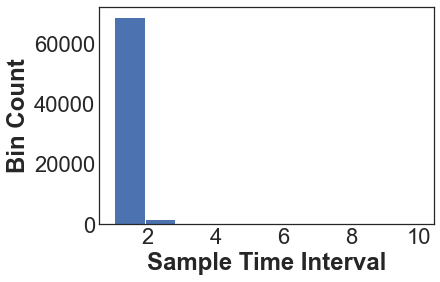

In [3]:
#show sample time interval histogram
plt.hist(np.diff(data_df.time))
plt.xlabel('Sample Time Interval');
plt.ylabel('Bin Count');

#Display bin count values as well
y = np.bincount(np.diff(data_df.time))
ii = np.nonzero(y)[0]
print(pd.DataFrame(np.vstack((ii,y[ii])).T,columns = ['Sample Time Interval','Value Count']))

**Observations:** For the most part the interval between samples is 1 ms (1000 Hz sampling rate), but there are some longer interval. To make life easier downstream in the analysis pipeline, I incorporate a stage to resample the data to a steady 1000 Hz sampling rate, linearly interpolating between missing values. This is quite fast and easy with pandas

### Checking Data Quality

&emsp; One of the first things to check with any data set is the quality of the data and check for any of the following: line noise: obvious artifacts, slow drifts over time, large noise signals, or any other concerns one might have given the source of the data.

&emsp; Below, I plot the timecourse of both data files for a given subject and the power spectrum of the data for a small portion of the timecourse. There are two obvious concerns with EMG data: 1) electrophysisiological data is susceptible to line noise (50 Hz in Europe or 60 Hz in North America), and 2) the fact that these signals are coming from a wearable device while subjects are performing motions means that movement-related artifacts are possible. The first concern can be addressed with a notch filter. The second concern can be addressed by identifying artifacts (maybe a large flucturation in the signal when subject begins movement) and excluding affected time points or regressing out the artifacts if we have something like a reference electrode.

The plots below show the timecourse and power spectrum for the loaded subjects' data.

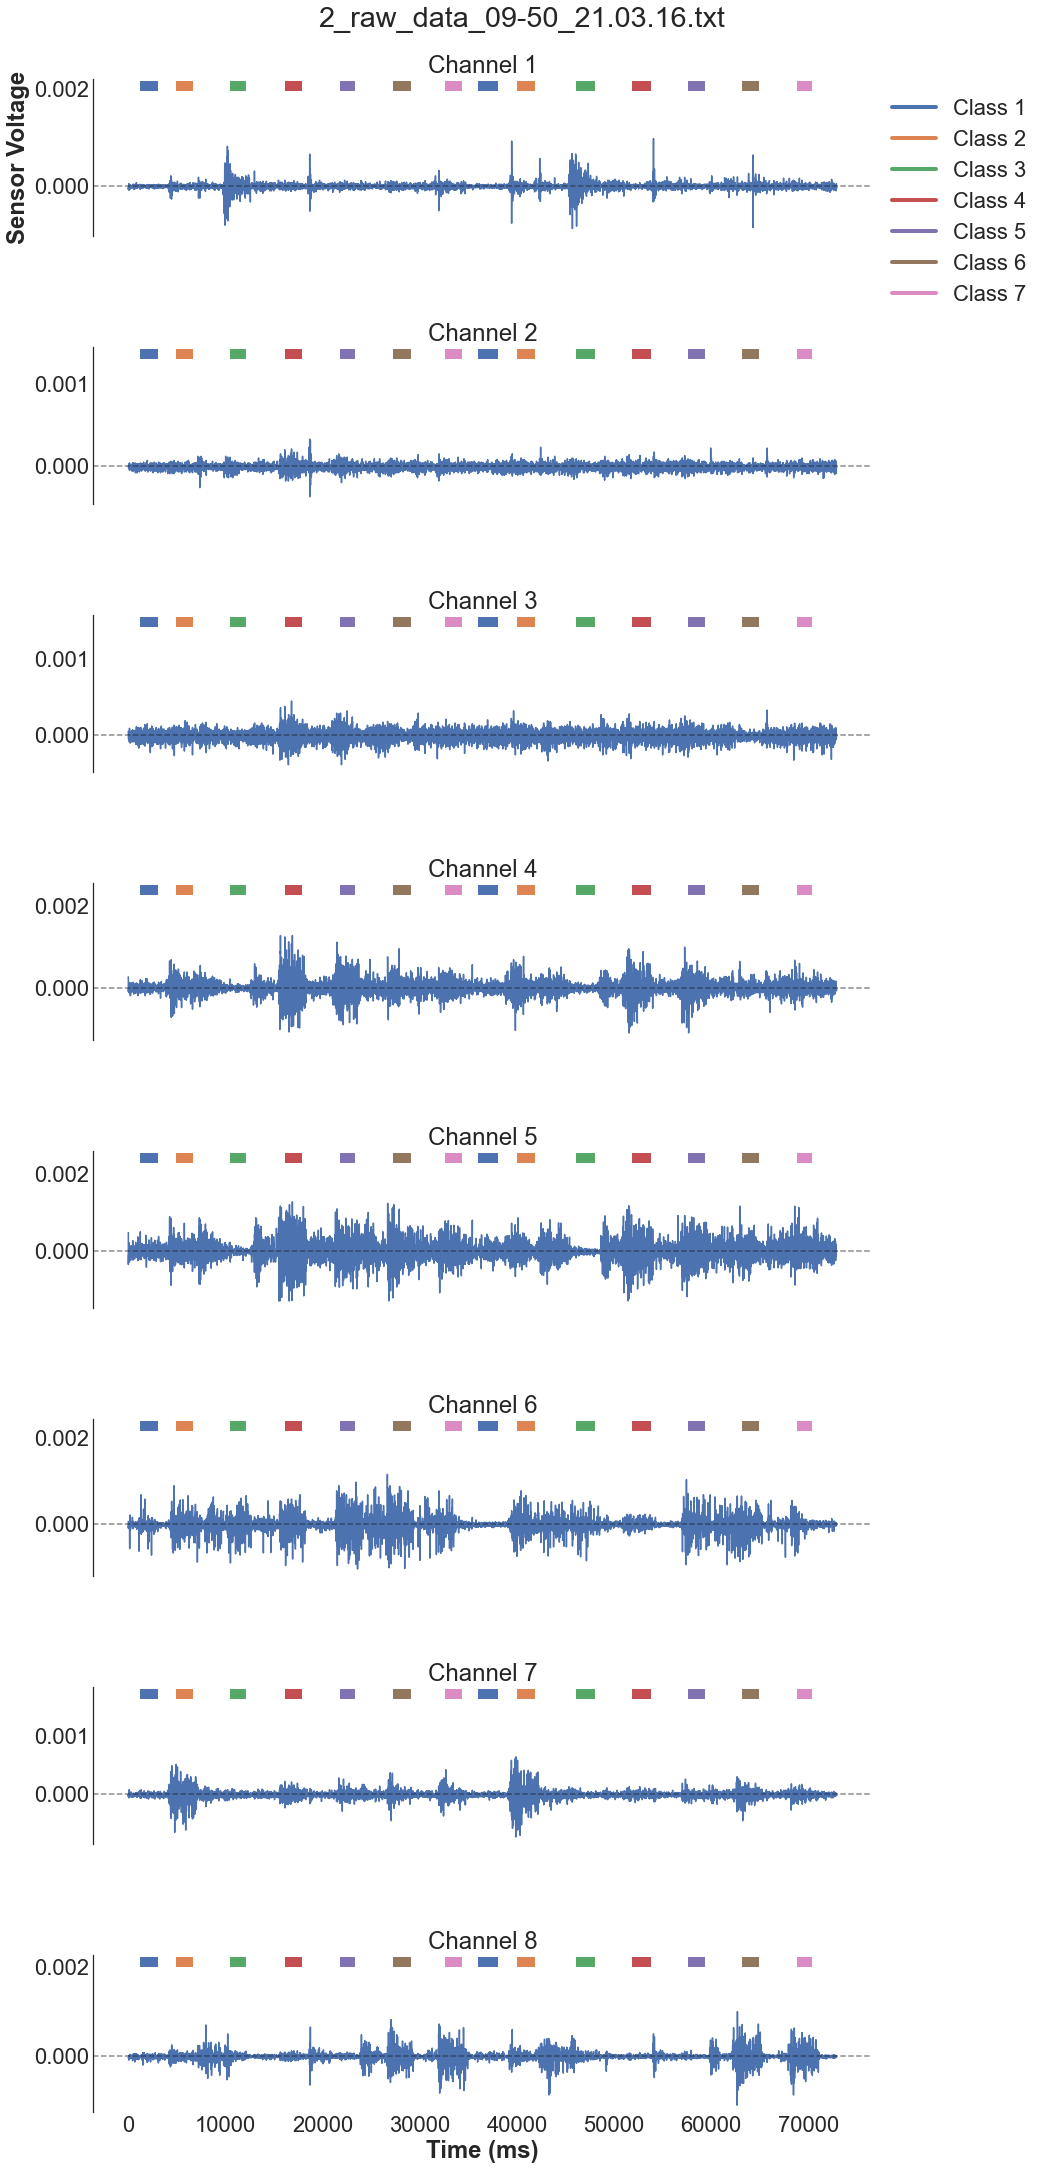

In [4]:
# Plotting timecourse for first file
file_idx = 0
data_fn = os.path.join(data_folder,file_list[file_idx])
fig = plot_sensor_values(data_fn, x_limits= [])
fig.suptitle('%s'%(file_list[file_idx]), y = 1.01);

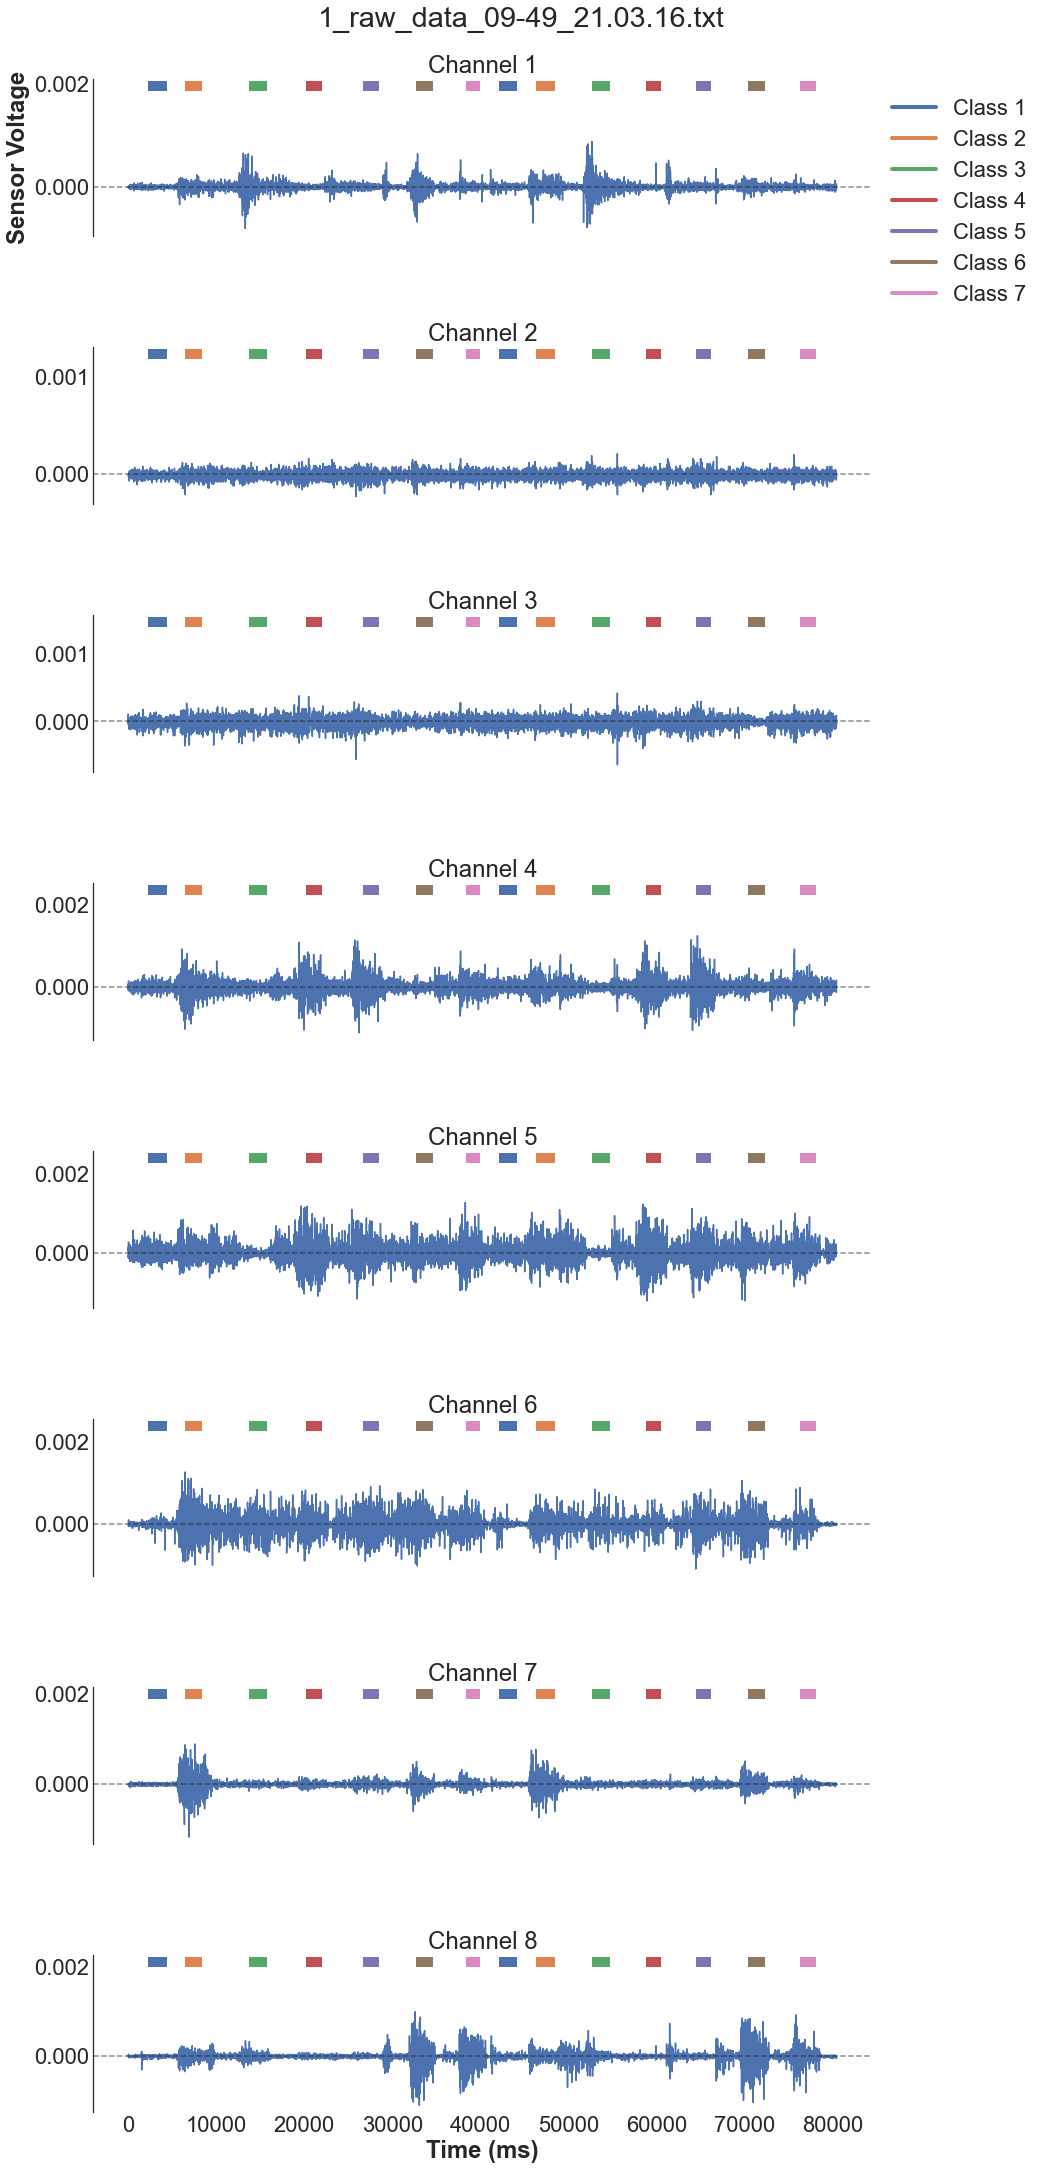

In [5]:
# Plotting timecourse for second file
file_idx = 1
data_fn = os.path.join(data_folder,file_list[file_idx])
fig = plot_sensor_values(data_fn, x_limits= [])
fig.suptitle('%s'%(file_list[file_idx]), y = 1.01);

**Observations:** The two series of plots above show the electrode voltage over time for each channel with the limb position label for each time point marked above the plot. Each series of plots corresponds to a 60-80 second period of time in which subjects took each of the limb positions twice. 
Overall, the data quality is good, there are no obvious artifacts or slow drift of the data. 
Looking at the data in the frequency domain is also helpful since there may be noise that is not obvious whenlooking at the time series.

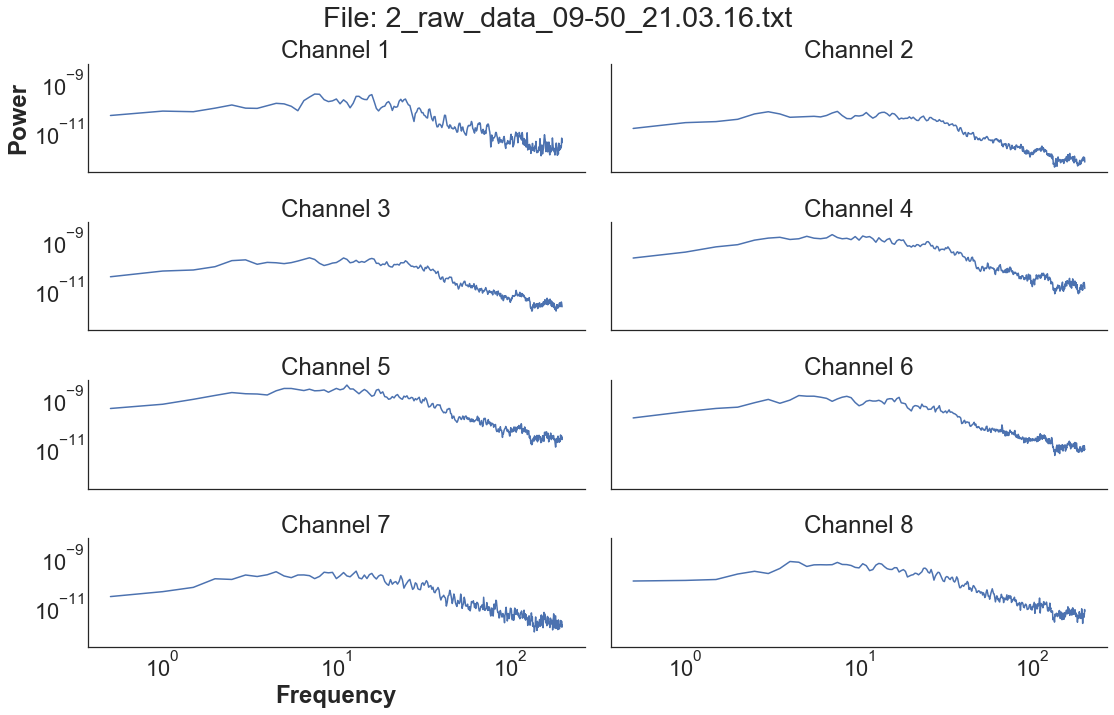

In [6]:
# Power spectrum for first file
file_idx = 0
data_fn = os.path.join(data_folder,file_list[file_idx])
fig = plot_signal_pspec(data_fn)
fig.suptitle('File: %s'%(file_list[file_idx]), y = 1.01);

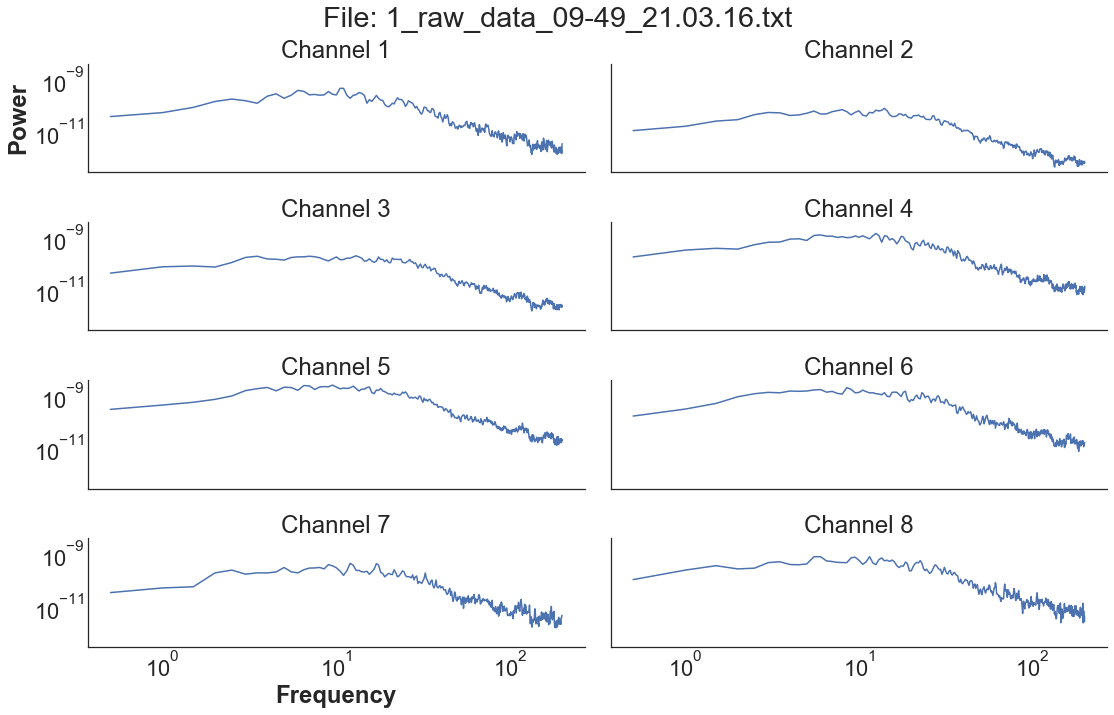

In [7]:
# Power spectrum for second file
file_idx = 1
data_fn = os.path.join(data_folder,file_list[file_idx])
fig = plot_signal_pspec(data_fn)
fig.suptitle('File: %s'%(file_list[file_idx]), y = 1.01);

**Observations:** The two groups of plots above show the power of the signal at different frequencies. I limited the view of these plots to 100 Hz since I was mostly concerned about line noise (50 Hz since these data were collected in Europe). As can be seen, there are no peaks in the power spectra of the channels at these frequencies. 


### Signal Filtering

&emsp; EMG data is typically bandpass filtered with a filter lower-bound between 5-25 Hz and a filter upper-bound of 450 Hz. For this reason, I incoroporate a bandpass filter (20-450 Hz) in the data processing pipeline. 

&emsp; Knowing that the quality of the data is good and having made decision about the pre-processing steps to take with our data, we can move on to the next step: building informative features. 